In [1]:
import pandas as pd

# Load the CSV created by the test
df = pd.read_csv("../tests/data/measures/brier_score_breast_cancer.csv")
df

,model,brier_score
0,Logistic Regression,0.025349
1,Random Forest,0.025520
2,Gradient Boosting,0.032814
3,SVC (probabilities),0.034043


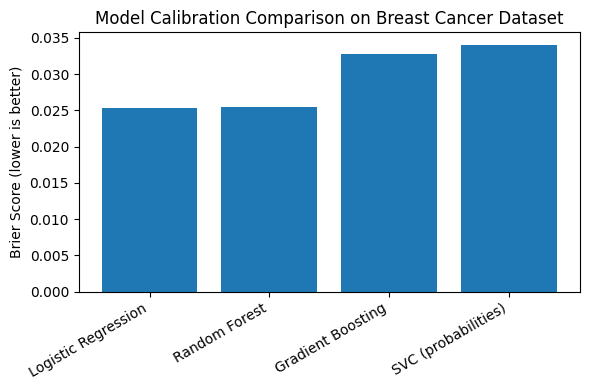

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(df["model"], df["brier_score"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Brier Score (lower is better)")
plt.title("Model Calibration Comparison on Breast Cancer Dataset")
plt.tight_layout()
plt.show()

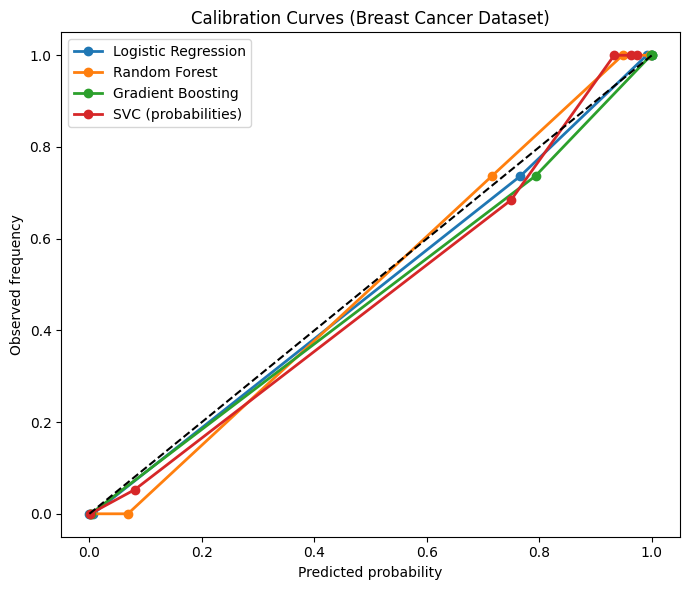

In [5]:
# Cell 3 – Calibration (reliability) curves

plt.figure(figsize=(7, 6))

for name, model in models.items():
    # retrain to be safe (cheap)
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]

    # use quantile bins to avoid crazy zig-zags
    frac_pos, mean_pred_prob = calibration_curve(
        y_test, probs, n_bins=6, strategy="quantile"
    )

    # sort points by predicted probability
    order = np.argsort(mean_pred_prob)

    plt.plot(
        mean_pred_prob[order],
        frac_pos[order],
        marker="o",
        linewidth=2,
        label=name,
    )

# ideal diagonal
plt.plot([0, 1], [0, 1], "--", color="black")

plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curves (Breast Cancer Dataset)")
plt.legend()
plt.tight_layout()
plt.show()

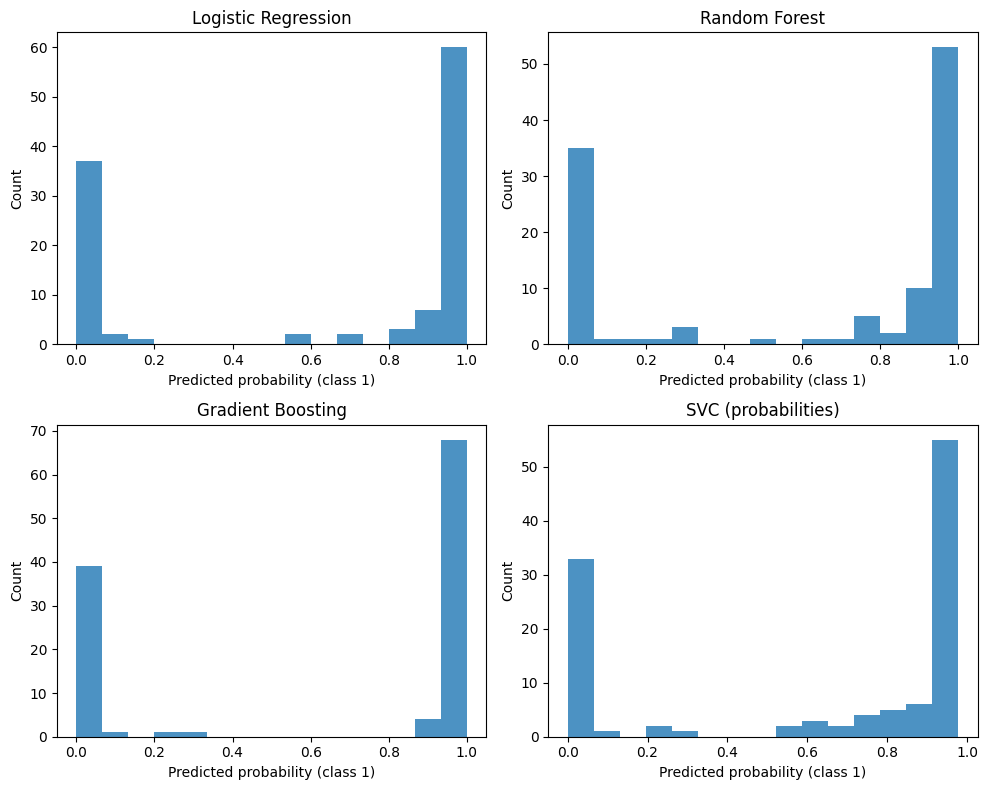

In [6]:
# Cell 4 – Histograms of predicted probabilities (confidence profiles)

plt.figure(figsize=(10, 8))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(2, 2, i + 1)
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]

    plt.hist(probs, bins=15, alpha=0.8)
    plt.title(name)
    plt.xlabel("Predicted probability (class 1)")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

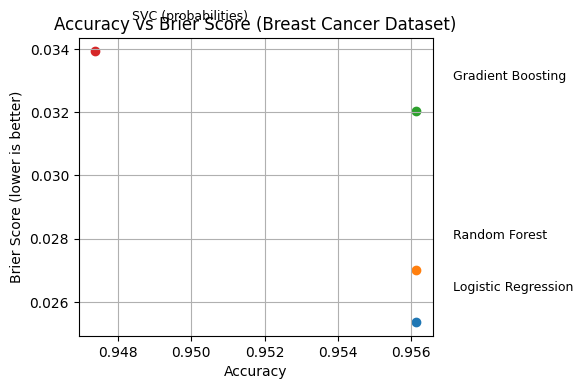

,model,accuracy,brier_score
0,Logistic Regression,0.956140,0.025349
1,Random Forest,0.956140,0.026996
2,Gradient Boosting,0.956140,0.032046
3,SVC (probabilities),0.947368,0.033937


In [7]:
# Cell 5 – Accuracy vs. Brier Score

plt.figure(figsize=(6, 4))

for _, row in df_metrics.iterrows():
    plt.scatter(row["accuracy"], row["brier_score"])
    plt.text(
        row["accuracy"] + 0.001,
        row["brier_score"] + 0.001,
        row["model"],
        fontsize=9,
    )

plt.xlabel("Accuracy")
plt.ylabel("Brier Score (lower is better)")
plt.title("Accuracy vs Brier Score (Breast Cancer Dataset)")
plt.grid(True)
plt.tight_layout()
plt.show()

df_metrics

In [3]:
seeds = range(10)  # 10 different random splits
rows = []

for seed in seeds:
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    for name, model in models.items():
        model.fit(X_train_s, y_train_s)
        probs = model.predict_proba(X_test_s)[:, 1]
        brier = brier_score_loss(y_test_s, probs)

        rows.append(
            {
                "seed": seed,
                "model": name,
                "brier_score": brier,
            }
        )

df_seeds = pd.DataFrame(rows)
df_seeds.head()

/Volumes/KALI_DRIVE/a4s-eval-public/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Volumes/KALI_DRIVE/a4s-eval-public/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://sciki

,seed,model,brier_score
0,0,Logistic Regression,0.036018
1,0,Random Forest,0.027612
2,0,Gradient Boosting,0.022278
3,0,SVC (probabilities),0.046637
4,1,Logistic Regression,0.043018


/var/folders/gr/04wprkx53hg82g9p3n8cp_zc0000gn/T/ipykernel_22856/1389630551.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=order)


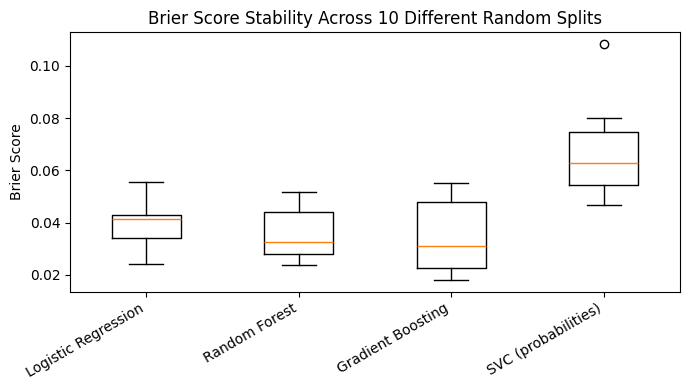

In [4]:
plt.figure(figsize=(7, 4))

# Sort models for consistent ordering
order = ["Logistic Regression", "Random Forest", "Gradient Boosting", "SVC (probabilities)"]

data_to_plot = [df_seeds[df_seeds["model"] == m]["brier_score"] for m in order]

plt.boxplot(data_to_plot, labels=order)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Brier Score")
plt.title("Brier Score Stability Across 10 Different Random Splits")
plt.tight_layout()
plt.show()

In [5]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_results = []

# We'll calibrate Random Forest and Gradient Boosting
to_calibrate = ["Random Forest", "Gradient Boosting"]

for name in to_calibrate:
    base_model = models[name]

    # Wrap the model with a calibrator (isotonic or sigmoid)
    calib = CalibratedClassifierCV(base_model, method="isotonic", cv=3)

    # Fit on training data
    calib.fit(X_train, y_train)

    # Evaluate on test data
    y_pred = calib.predict(X_test)
    y_proba = calib.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    brier = brier_score_loss(y_test, y_proba)

    calibrated_results.append(
        {
            "model": name + " (calibrated)",
            "accuracy": acc,
            "brier_score": brier,
        }
    )

df_calibrated = pd.DataFrame(calibrated_results)
df_calibrated

,model,accuracy,brier_score
0,Random Forest (calibrated),0.964912,0.022643
1,Gradient Boosting (calibrated),0.956140,0.032713


In [6]:
df_all = pd.concat([df_metrics, df_calibrated], ignore_index=True)
df_all_sorted = df_all.sort_values("brier_score")

df_all_sorted

,model,accuracy,brier_score
4,Random Forest (calibrated),0.964912,0.022643
0,Logistic Regression,0.956140,0.025200
1,Random Forest,0.964912,0.026130
2,Gradient Boosting,0.956140,0.032131
5,Gradient Boosting (calibrated),0.956140,0.032713
3,SVC (probabilities),0.947368,0.034622


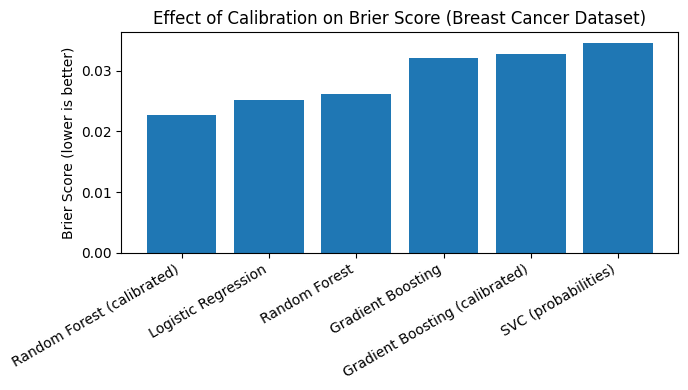

In [7]:
plt.figure(figsize=(7, 4))
plt.bar(df_all_sorted["model"], df_all_sorted["brier_score"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Brier Score (lower is better)")
plt.title("Effect of Calibration on Brier Score (Breast Cancer Dataset)")
plt.tight_layout()
plt.show()

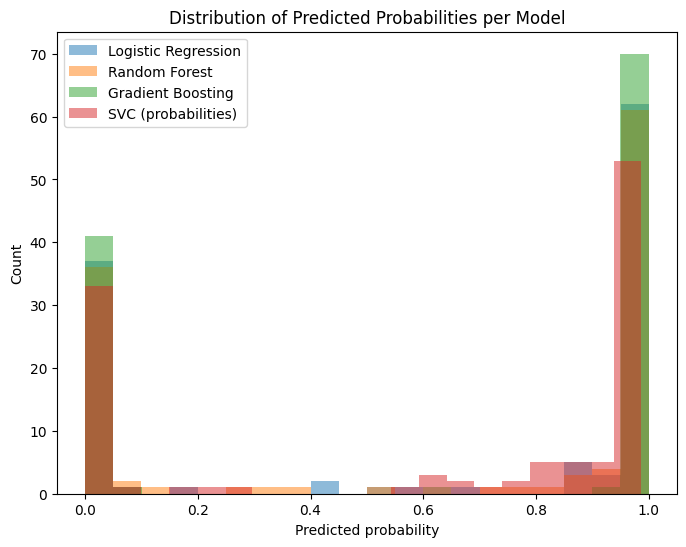

In [8]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    probs = model.predict_proba(X_test)[:, 1]
    plt.hist(probs, bins=20, alpha=0.5, label=name)

plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities per Model")
plt.legend()
plt.show()

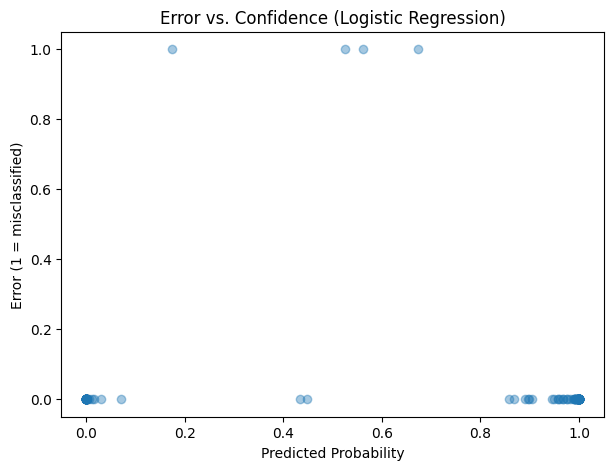

In [9]:
plt.figure(figsize=(7,5))

probs = models["Logistic Regression"].predict_proba(X_test)[:,1]
errors = (models["Logistic Regression"].predict(X_test) != y_test).astype(int)

plt.scatter(probs, errors, alpha=0.4)
plt.xlabel("Predicted Probability")
plt.ylabel("Error (1 = misclassified)")
plt.title("Error vs. Confidence (Logistic Regression)")
plt.show()

In [10]:
from sklearn.calibration import calibration_curve

def brier_decomposition(y_true, prob_pred):
    bins = 10
    prob_true, prob_pred_bin = calibration_curve(y_true, prob_pred, n_bins=bins)

    # Calibration error
    cal_error = np.mean((prob_pred_bin - prob_true)**2)

    # Refinement = variance of predictions
    refinement = np.var(prob_pred)

    return cal_error, refinement

for name, model in models.items():
    probs = model.predict_proba(X_test)[:,1]

    cal, ref = brier_decomposition(y_test, probs)
    print(f"{name}: Calibration={cal:.4f}, Refinement={ref:.4f}")

Logistic Regression: Calibration=0.2342, Refinement=0.2107
Random Forest: Calibration=0.0716, Refinement=0.2093
Gradient Boosting: Calibration=0.1329, Refinement=0.2287
SVC (probabilities): Calibration=0.0702, Refinement=0.1828
